### SAMPLE RUN – NOT LATEST

In [ ]:
import torch
import random
from torchvision import transforms
import os
import numpy as np
from torchvision import models
from PIL import Image
model_to_train = "vit"

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/train/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos")


Resolving data files:   0%|          | 0/405 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
if model_to_train == "vit":
    seed = 42
elif model_to_train == "segformer":
    seed = 42
elif model_to_train == "swin":
    seed = 42

dataset = dataset.shuffle(seed = seed)

In [ ]:
dataset['test'] = dataset['train'].train_test_split(test_size = 0.1)
dataset['train'] = dataset['test']['train']
del dataset['test']['train']
dataset['test'] = dataset['test']['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 360
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 40
    })
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import ViTFeatureExtractor, AutoImageProcessor

if model_to_train == "vit":
    model_name_or_path = 'google/vit-base-patch16-224'
    extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
elif model_to_train == "segformer":
    model_name_or_path = 'nvidia/mit-b0'
    extractor = AutoImageProcessor.from_pretrained(model_name_or_path)
elif model_to_train == "swin":
    model_name_or_path = "microsoft/swinv2-tiny-patch4-window8-256"
    extractor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision import transforms
import torch
preprocessing_transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.GaussianBlur(9),
    transforms.RandomApply(torch.nn.ModuleList([
        transforms.ColorJitter(brightness= (0.9, 1.1), contrast = (1.0, 1.1), saturation = (1.0, 2.0), hue = (-0.1, 0.1)),
    ]), p=0.2),
])

style_transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [ ]:
def transformation(batch):
    inputs = extractor([preprocessing_transformation(x) for x in batch['image']], return_tensors = "pt")
    inputs['label'] = batch['label']
    return inputs

In [ ]:
prepared_ds = dataset.with_transform(transformation)

In [ ]:
import torch

def collate_function(example_batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in example_batch]),
        'labels': torch.tensor([x['label'] for x in example_batch])
    }

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
from transformers import ViTForImageClassification, SegformerForImageClassification, Swinv2ForImageClassification

labels = dataset['train'].features['label'].names

if model_to_train == "vit":
    model = ViTForImageClassification.from_pretrained(
        model_name_or_path,
        num_labels=len(labels),
        id2label={str(i): c for i, c in enumerate(labels)},
        label2id={c: str(i) for i, c in enumerate(labels)},
        ignore_mismatched_sizes = True
    ).to(device)
elif model_to_train == "segformer":
    model = SegformerForImageClassification.from_pretrained(
        model_name_or_path,
        num_labels=len(labels),
        id2label={str(i): c for i, c in enumerate(labels)},
        label2id={c: str(i) for i, c in enumerate(labels)},
        ignore_mismatched_sizes = True
    ).to(device)
elif model_to_train == "swin":
    model = Swinv2ForImageClassification.from_pretrained(
        model_name_or_path,
        num_labels=len(labels),
        id2label={str(i): c for i, c in enumerate(labels)},
        label2id={c: str(i) for i, c in enumerate(labels)},
        ignore_mismatched_sizes = True
    ).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

if model_to_train == "vit":
    output_dir = "./histo_train_vit"
elif model_to_train == "segformer":
    output_dir = "./histo_train_segformer"
elif model_to_train == "swin":
    output_dir = "./histo_train_swin"

args = TrainingArguments(
  output_dir=output_dir,
  per_device_train_batch_size=64,
  evaluation_strategy="steps",
  num_train_epochs=20,
  fp16=True,
  save_steps=100,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
    
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import Trainer

histo_trainer = Trainer(
    model = model, 
    args = args, 
    data_collator = collate_function,
    compute_metrics = compute_metrics,
    train_dataset = prepared_ds['train'],
    eval_dataset = prepared_ds['test'],
    tokenizer = extractor
)

/content/./histo_train_vit is already a clone of https://huggingface.co/tcvrishank/histo_train_vit. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
results = histo_trainer.train()
histo_trainer.save_model()
histo_trainer.log_metrics("train", results.metrics)
histo_trainer.save_metrics("train", results.metrics)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.048100,0.492564,0.825000
20,0.371400,0.338763,0.900000
30,0.064200,0.325490,0.875000
40,0.019900,0.411129,0.875000
50,0.007400,0.333428,0.925000
60,0.002400,0.370973,0.900000
70,0.013100,0.536622,0.850000
80,0.006700,0.517248,0.875000
90,0.015200,0.483464,0.900000
100,0.005800,0.397908,0.875000


To https://huggingface.co/tcvrishank/histo_train_vit
   996b0f1..b1854c4  main -> main

   996b0f1..b1854c4  main -> main

To https://huggingface.co/tcvrishank/histo_train_vit
   b1854c4..123304e  main -> main

   b1854c4..123304e  main -> main



***** train metrics *****
  epoch                    =        20.0
  total_flos               = 519633597GF
  train_loss               =      0.1296
  train_runtime            =  0:18:13.95
  train_samples_per_second =       6.582
  train_steps_per_second   =        0.11


In [ ]:
result_metrics = histo_trainer.evaluate(prepared_ds['test'])
histo_trainer.log_metrics("eval", result_metrics)
histo_trainer.save_metrics("eval", result_metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =      0.875
  eval_loss               =     0.5316
  eval_runtime            = 0:00:04.19
  eval_samples_per_second =      9.541
  eval_steps_per_second   =      1.193


In [ ]:
from ensemble_transformers import EnsembleModelForImageClassification
ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(
    "tcvrishank/histo_train_vit", "tcvrishank/histo_train_segformer", "tcvrishank/histo_train_swin"
)

    

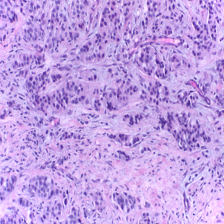

In [ ]:
from PIL import Image
image = Image.open("/content/test32.tif")
image = image.resize((224, 224))
image

In [ ]:
import gradio as gr
import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from PIL import Image

from ensemble_transformers import EnsembleModelForImageClassification
ensemble = EnsembleModelForImageClassification.from_multiple_pretrained(
    "tcvrishank/histo_train_vit", "tcvrishank/histo_train_segformer", "tcvrishank/histo_train_swin"
)

candidate_labels = ["Benign", "InSitu", "Invasive", "Normal"]

def return_prediction(image):
  
    with torch.no_grad():
        outputs = ensemble(image, mean_pool = True)

    logits = outputs.logits[0]
    probs = logits.softmax(dim=-1).numpy()
    scores = probs.tolist()

    result = [
        {"score": score, "label": candidate_label}
        for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
    ]
    result = result[0]
    final = f"This histopathology image shows cells that are {round(result['score'] * 100, 2)}% certain to be {result['label']}."
    return final


demo = gr.Interface(fn=return_prediction, inputs="image", outputs="text")
    
demo.launch(share = True)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://479d646733093b5130.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
